# Wildfire Time Series Decomposition using STL

This notebook demonstrates Seasonal-Trend decomposition using LOESS (STL) on wildfire data to identify:
- Long-term trends
- Seasonal patterns
- Residual components

Data requirements:
- Time series of wildfire metrics (counts, area burned, etc.)
- Regular time intervals (daily, monthly, etc.)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from statsmodels.tsa.seasonal import STL
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## 1. Data Preparation
Load and preprocess wildfire time series data

In [2]:
df = pd.read_csv(r'/media/scruffy/Elements/python_data/Final/Prepared_Data/wildfires_california.csv')

In [18]:
gdf = gpd.read_file(r'/media/scruffy/Elements/python_data/Final/Prepared_Data/wildfires_california.geojson')

In [4]:
df = df.sort_values('ALARM_DATE', ascending=False).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22810 entries, 0 to 22809
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR_                22733 non-null  float64
 1   STATE                22810 non-null  object 
 2   AGENCY               22761 non-null  object 
 3   UNIT_ID              22749 non-null  object 
 4   FIRE_NAME            22638 non-null  object 
 5   INC_NUM              21839 non-null  object 
 6   IRWINID              3142 non-null   object 
 7   ALARM_DATE           17414 non-null  object 
 8   CONT_DATE            10180 non-null  object 
 9   C_METHOD             10708 non-null  float64
 10  CAUSE                22810 non-null  int64  
 11  COMPLEX_NAME         600 non-null    object 
 12  COMPLEX_ID           566 non-null    object 
 13  OBJECTIVE            22539 non-null  float64
 14  GIS_ACRES            22810 non-null  float64
 15  COMMENTS             2835 non-null  

In [5]:
# Convert strings to timedate objects
df["ALARM_DATE"] = pd.to_datetime(df["ALARM_DATE"])
df["CONT_DATE"] = pd.to_datetime(df["CONT_DATE"])
#df["days_to_containment"] = pd.to_timedelta(df["days_to_containment"])


In [6]:
cols = [
    'YEAR_',
    'FIRE_NAME',
    'ALARM_DATE',
    'CONT_DATE',
    'GIS_ACRES',
    'Shape_Length',
    'Shape_Area',
    'cause_name',
    'cause_src',
    'days_to_containment'
]

In [7]:
df = df[cols]
df_prep = df[df['ALARM_DATE'].isna()==False]
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   YEAR_                17414 non-null  float64            
 1   FIRE_NAME            17316 non-null  object             
 2   ALARM_DATE           17414 non-null  datetime64[ns, UTC]
 3   CONT_DATE            10170 non-null  datetime64[ns, UTC]
 4   GIS_ACRES            17414 non-null  float64            
 5   Shape_Length         17414 non-null  float64            
 6   Shape_Area           17414 non-null  float64            
 7   cause_name           17403 non-null  object             
 8   cause_src            17403 non-null  object             
 9   days_to_containment  10170 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(5), object(3)
memory usage: 1.5+ MB


In [8]:
df_group = df_prep.groupby('ALARM_DATE').agg(
                                    fire_count=('FIRE_NAME', 'count'),
                                    acres_burned=('GIS_ACRES', 'sum'),
                                    longest_fire=('days_to_containment', 'max')
                                        )

df_group.info()
#df_group.sort_values('longest_fire', ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8966 entries, 1898-04-01 00:00:01+00:00 to 2025-01-22 00:00:00+00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   fire_count    8966 non-null   int64  
 1   acres_burned  8966 non-null   float64
 2   longest_fire  5104 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 280.2 KB


In [9]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [10]:
# Resample to consistent frequency (weekly shown, adjust as needed)
#gdf.set_index('date', inplace=True)
weekly = df_group.resample('W').agg({
    'fire_count': 'sum',
    'acres_burned': 'sum',
    'longest_fire': 'mean'
})

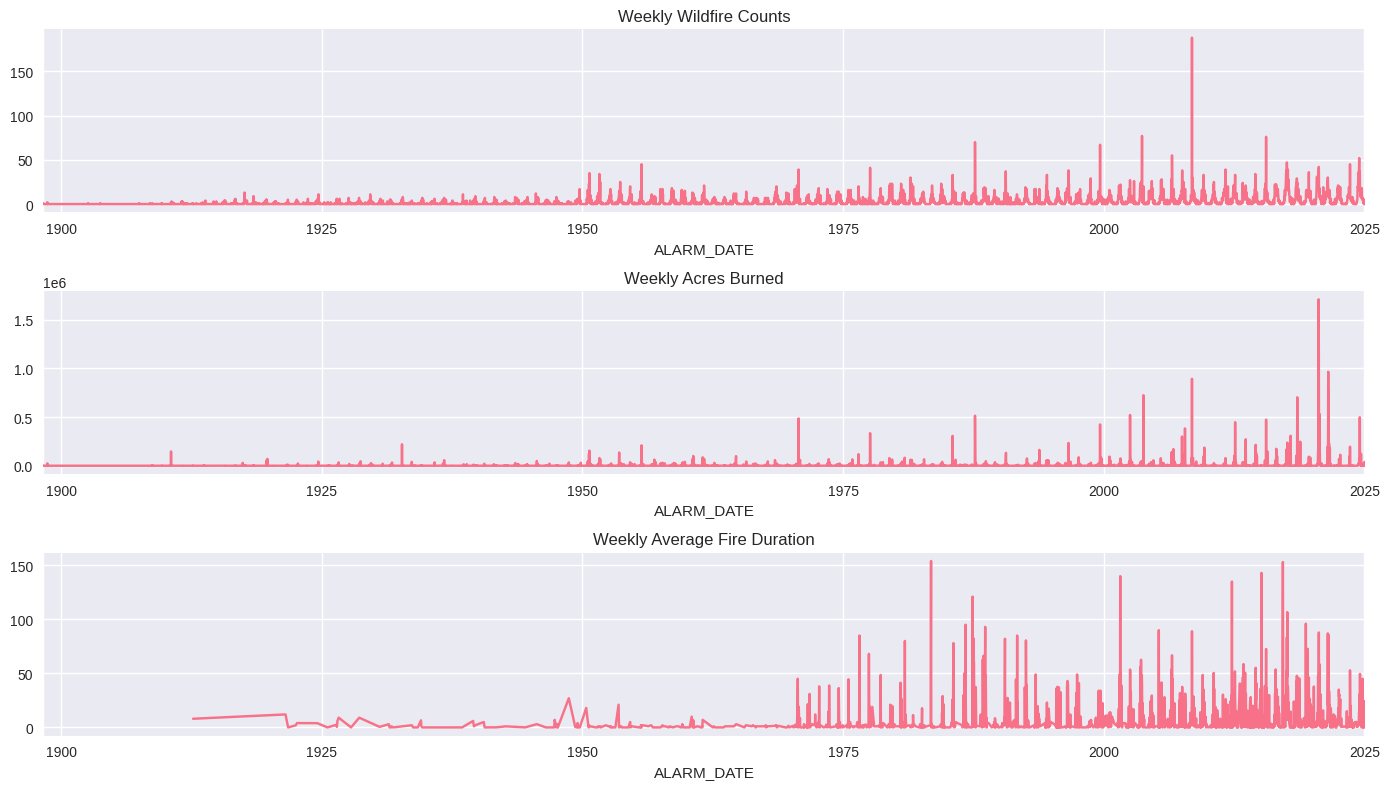

In [52]:
# Handle missing values (linear interpolation shown)
weekly = weekly.interpolate(method='linear')

# Visualize raw data
fig, ax = plt.subplots(3, 1, figsize=(14, 8))
weekly['fire_count'].plot(ax=ax[0], title='Weekly Wildfire Counts')
weekly['acres_burned'].plot(ax=ax[1], title='Weekly Acres Burned')
weekly['longest_fire'].plot(ax=ax[2], title='Weekly Average Fire Duration')
plt.tight_layout()
plt.show()

In [53]:
# Resample to consistent frequency (weekly shown, adjust as needed)
#gdf.set_index('date', inplace=True)
monthly = df_group.resample('ME').agg({
    'fire_count': 'sum',
    'acres_burned': 'sum',
    'longest_fire': 'max'
})

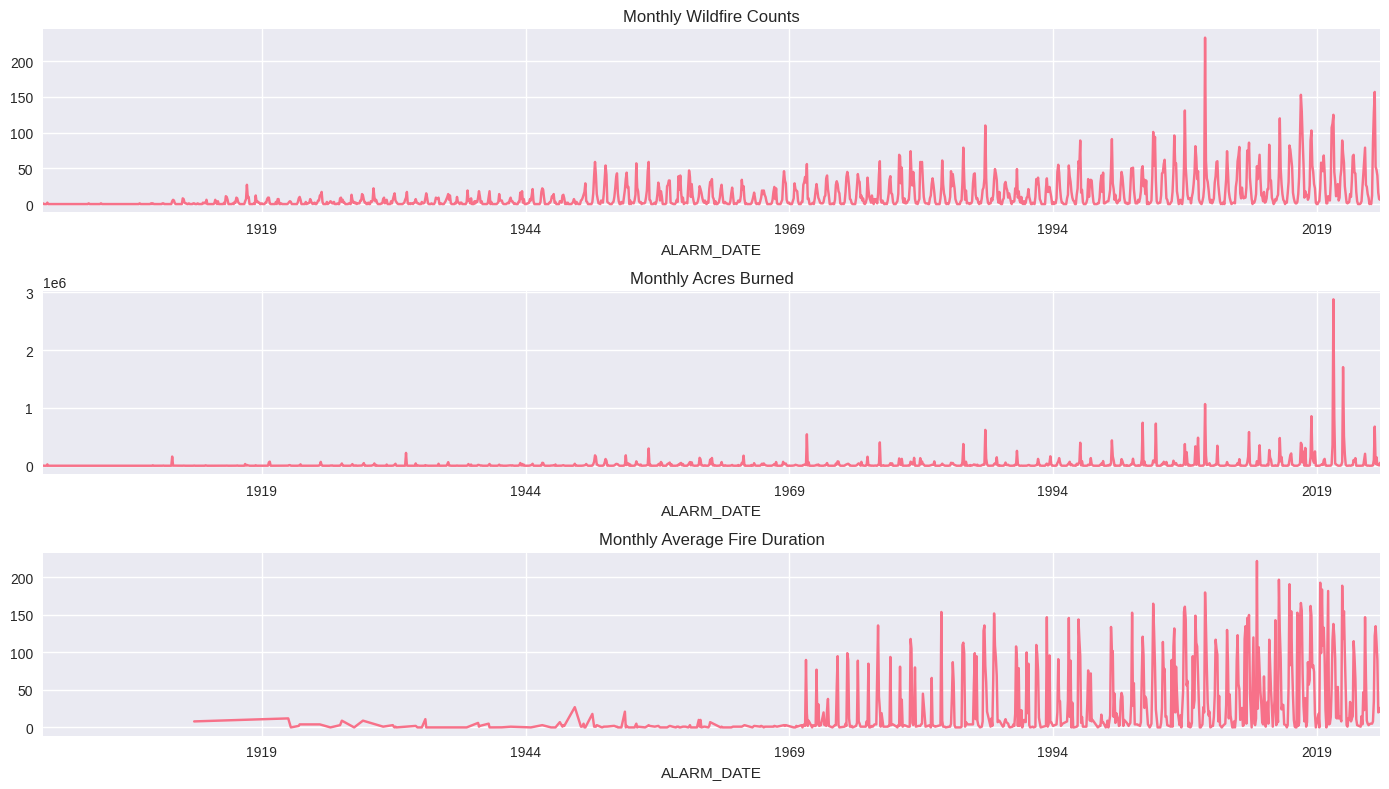

In [54]:
# Handle missing values (linear interpolation shown)
monthly = monthly.interpolate(method='linear')

# Visualize raw data
fig, ax = plt.subplots(3, 1, figsize=(14, 8))
monthly['fire_count'].plot(ax=ax[0], title='Monthly Wildfire Counts')
monthly['acres_burned'].plot(ax=ax[1], title='Monthly Acres Burned')
monthly['longest_fire'].plot(ax=ax[2], title='Monthly Average Fire Duration')
plt.tight_layout()
plt.show()

In [55]:
# Resample to consistent frequency (weekly shown, adjust as needed)
annual = df_group.resample('YE').agg({
    'fire_count': 'sum',
    'acres_burned': 'sum',
    'longest_fire': 'max'
})

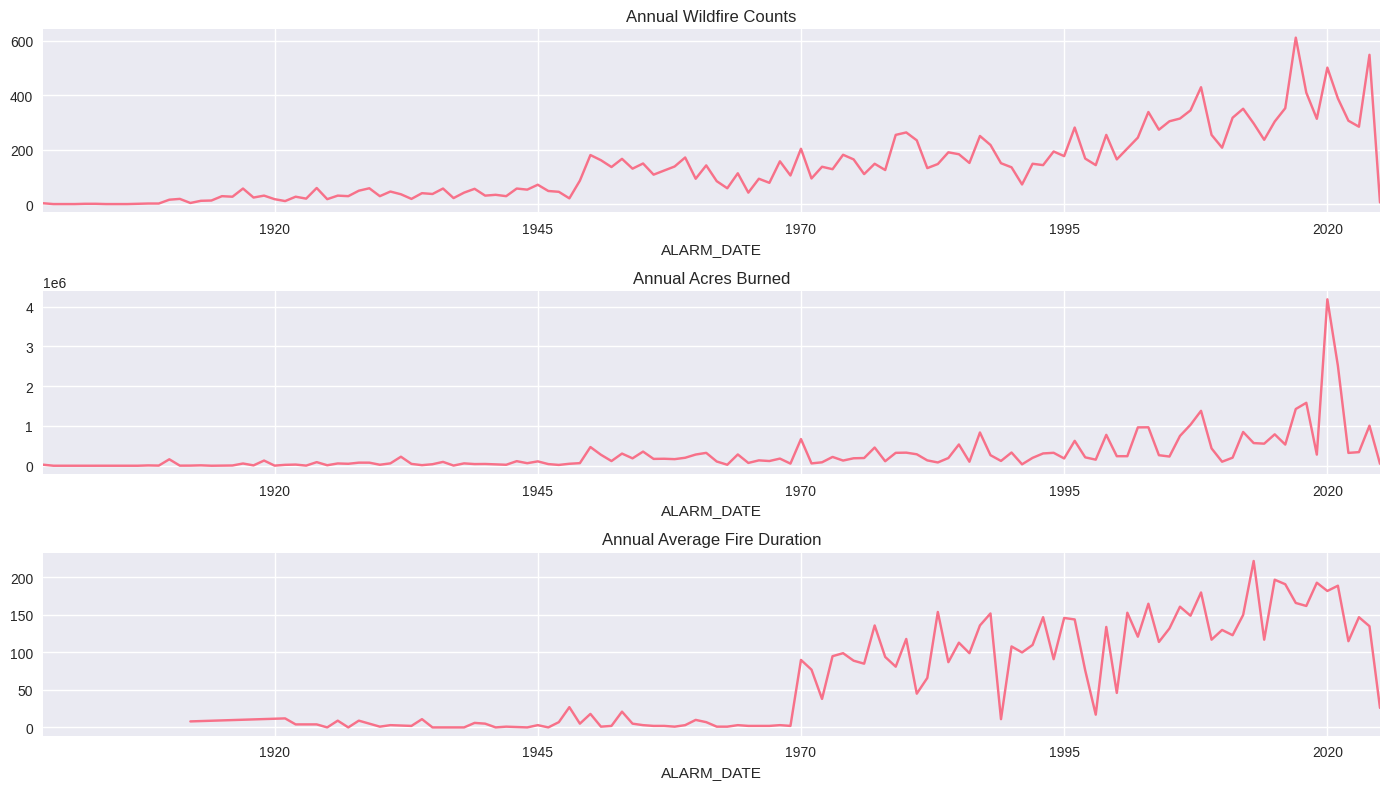

In [56]:
# Handle missing values
annual = annual.interpolate(method='linear')

# Visualize raw data
fig, ax = plt.subplots(3, 1, figsize=(14, 8))
annual['fire_count'].plot(ax=ax[0], title='Annual Wildfire Counts')
annual['acres_burned'].plot(ax=ax[1], title='Annual Acres Burned')
annual['longest_fire'].plot(ax=ax[2], title='Annual Average Fire Duration')
plt.tight_layout()
plt.show()

## 2. STL Decomposition Parameters
Configure the STL decomposition with appropriate parameters

In [57]:
# Key parameters to adjust:
# period: Length of seasonal cycle (52 for weekly data = yearly seasonality)
# seasonal: Length of seasonal smoother (odd integer)
# trend: Length of trend smoother (odd integer)
# robust: Use robust statistics for outliers

stl_params = {
    'period': 52,           # Weekly data → yearly seasonality
    'seasonal': 13,         # Smooth over ~3 months of weekly data
    'trend': 53,            # Smooth over ~1 year of weekly data
    'robust': True          # Reduce outlier impact
}

## 3. Decompose Fire Counts
Perform STL on wildfire occurrence counts

<Figure size 1400x1000 with 0 Axes>

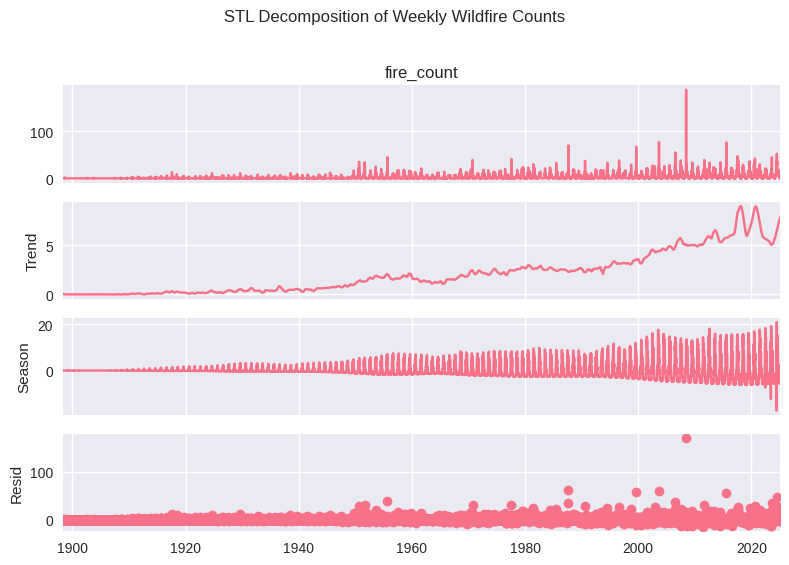

In [58]:
# STL decomposition
stl_firecount = STL(weekly['fire_count'], **stl_params).fit()

# Plot decomposition
plt.figure(figsize=(14, 10))
stl_firecount.plot()
plt.suptitle('STL Decomposition of Weekly Wildfire Counts', y=1.02)
plt.tight_layout()
plt.show()

## 4. Decompose Acres Burned
Perform STL on burned area metrics

<Figure size 1400x1000 with 0 Axes>

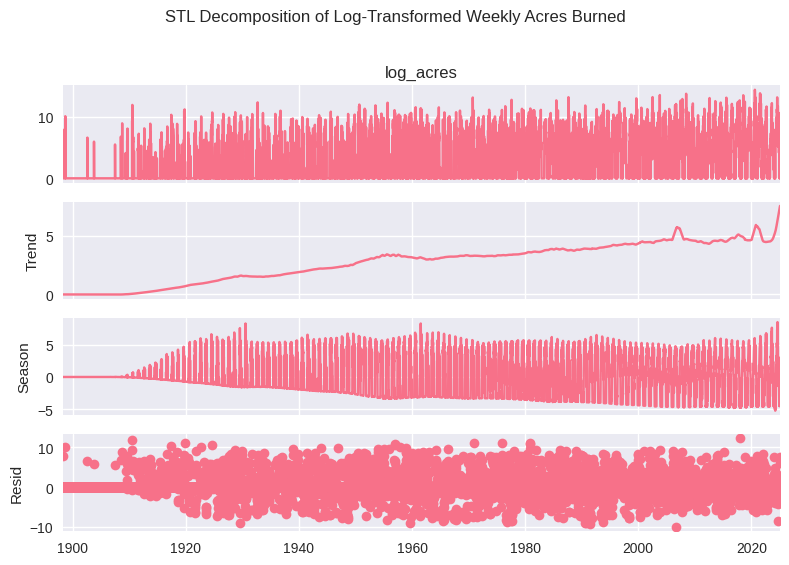

In [59]:
# For acres burned, we'll first log-transform due to right-skew
weekly['log_acres'] = np.log1p(weekly['acres_burned'])

stl_acres = STL(weekly['log_acres'], **stl_params).fit()

# Plot decomposition
plt.figure(figsize=(14, 10))
stl_acres.plot()
plt.suptitle('STL Decomposition of Log-Transformed Weekly Acres Burned', y=1.02)
plt.tight_layout()
plt.show()

    Both weekly number of fires and size of fires show strong positive trends that appear to be tightly correlated.
    Both also have pronounced seasonality.
    Much more noise in acres burned.

## 5. Checking for Stationarity
Perform Dickey-Fuller test for stationarity and visualize lag correlations for number of fires.

In [34]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(weekly['fire_count'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.758906e+01
p-value                        3.972356e-30
Number of Lags Used            1.400000e+01
Number of Observations Used    6.603000e+03
Critical Value (1%)           -3.431341e+00
Critical Value (5%)           -2.861978e+00
Critical Value (10%)          -2.567003e+00
dtype: float64


    The results from the Dickey-Fuller Stationarity Test suggest that the time-series is stationary, since the test statistic (roughly -17.6) is much smaller than all of the critical value levels.
    Therefore the null hypothesis can be rejected, theoretically proving that the data is stationary.
    This does not make sense because the time series has a very obvious trend, so I think something got messed up. I suspect this is related to there being one week that is an extreme outlier in number of fires recorded.

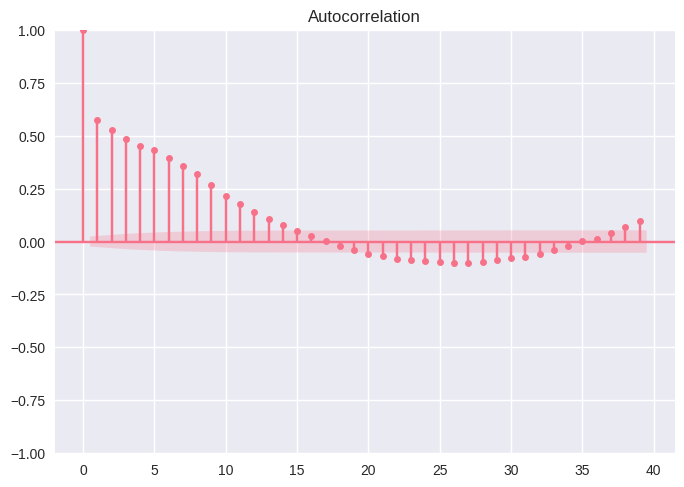

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(weekly['fire_count'])
plt.show()

    The time-series is very heavily auto-correlated.
    This makes sense - wildfires have a pronounced, well-defined season.

## 6. Component Analysis
Examine extracted components in detail

In [23]:
# STL decomposition
stl_firecount = STL(weekly['fire_count'], **stl_params).fit()
# For acres burned, we'll first log-transform due to right-skew
weekly['log_acres'] = np.log1p(weekly['acres_burned'])
stl_acres = STL(weekly['log_acres'], **stl_params).fit()

# Create DataFrame of components
components = pd.DataFrame({
    'fire_count': weekly['fire_count'],
    'fire_trend': stl_firecount.trend,
    'fire_seasonal': stl_firecount.seasonal,
    'fire_resid': stl_firecount.resid,
    'log_acres_trend': stl_acres.trend,
    'log_acres_seasonal': stl_acres.seasonal,
    'log_acres_resid': stl_acres.resid
}, index=weekly.index)

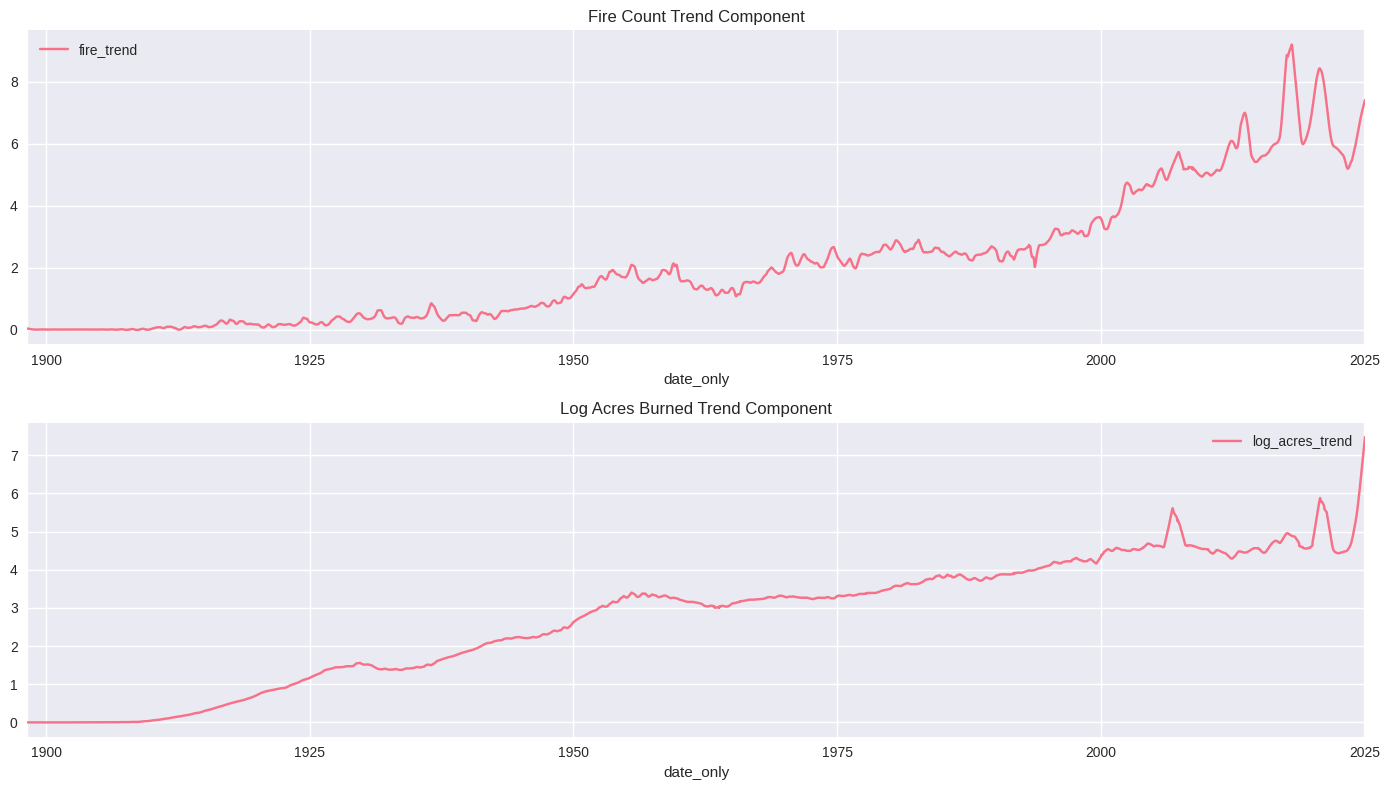

In [72]:
# Plot trend components
fig, ax = plt.subplots(2, 1, figsize=(14, 8))
components[['fire_trend']].plot(ax=ax[0], title='Fire Count Trend Component')
components[['log_acres_trend']].plot(ax=ax[1], title='Log Acres Burned Trend Component')
plt.tight_layout()
plt.show()

## 7. Seasonal Analysis
Examine seasonal patterns

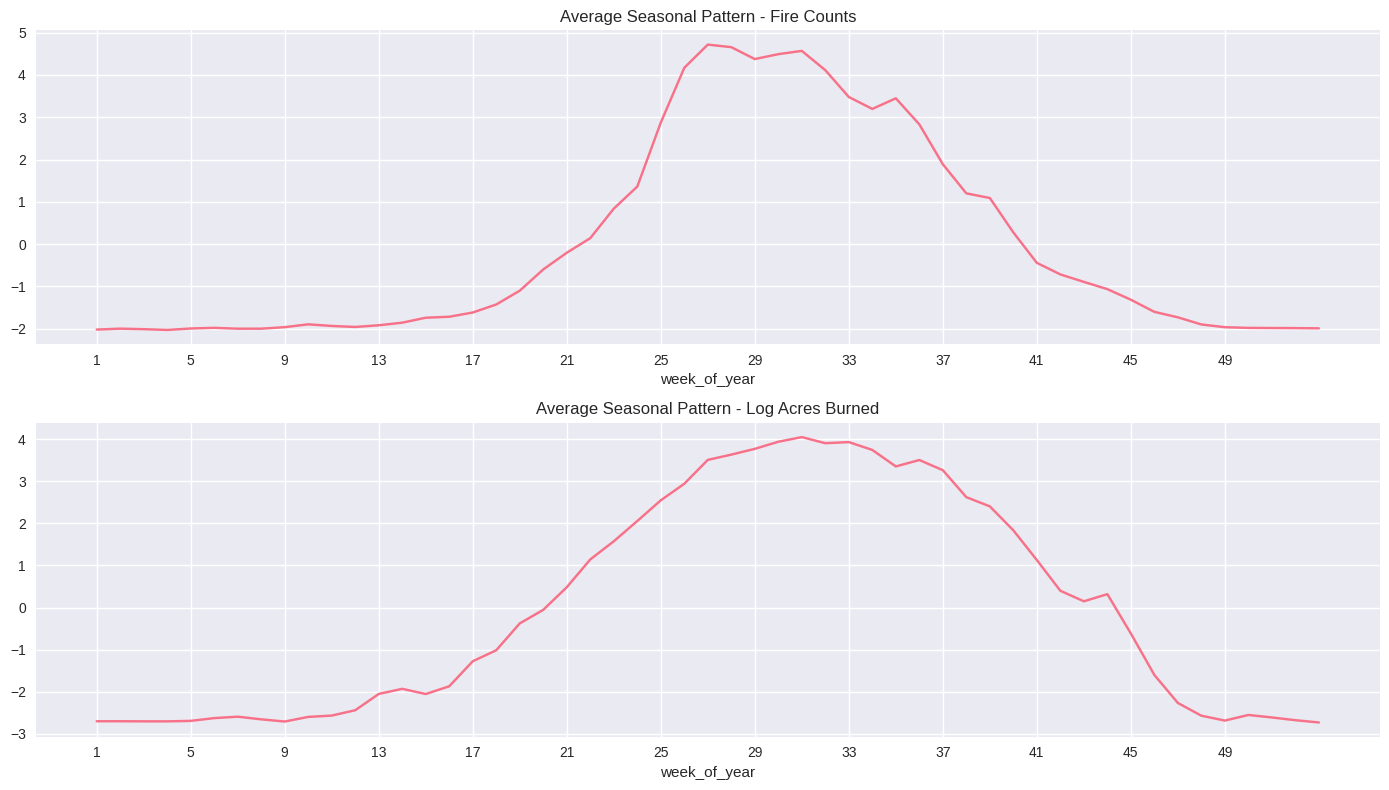

In [81]:
# Extract seasonal component by week of year
components['week_of_year'] = components.index.isocalendar().week
seasonal_avg = components.groupby('week_of_year')[['fire_seasonal', 'log_acres_seasonal']].mean()

# Plot seasonal patterns
fig, ax = plt.subplots(2, 1, figsize=(14, 8))
seasonal_avg['fire_seasonal'].plot(ax=ax[0], title='Average Seasonal Pattern - Fire Counts')
seasonal_avg['log_acres_seasonal'].plot(ax=ax[1], title='Average Seasonal Pattern - Log Acres Burned')
for a in ax:
    a.set_xticks(range(1, 53, 4))
plt.tight_layout()
plt.show()

## 8. Residual Analysis
Examine remaining patterns after removing trend and seasonality

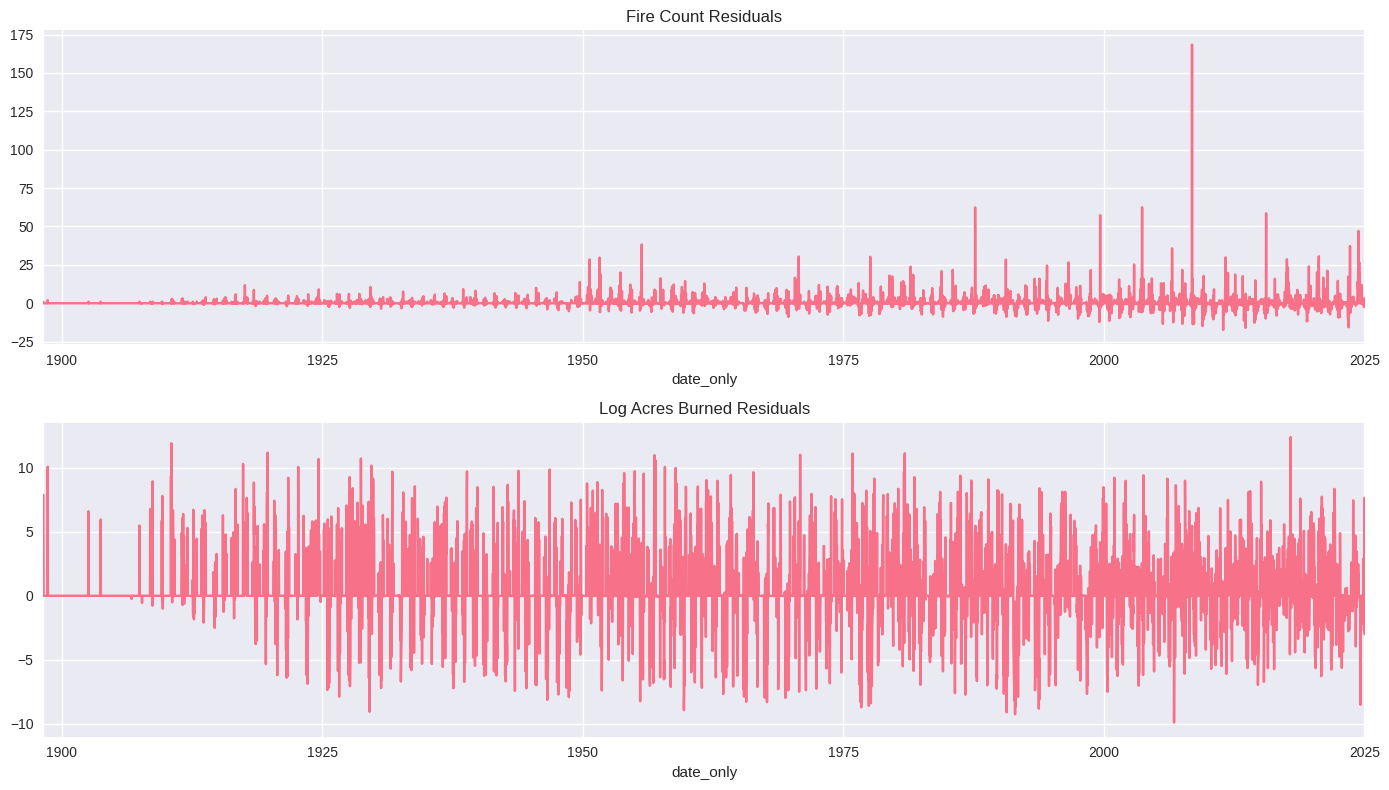

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8))
components['fire_resid'].plot(ax=ax[0], title='Fire Count Residuals')
components['log_acres_resid'].plot(ax=ax[1], title='Log Acres Burned Residuals')
plt.tight_layout()
plt.show()

In [80]:
# Check residual statistics
print("Fire Count Residuals:")
print(components['fire_resid'].describe())
print("\nLog Acres Burned Residuals:")
print(components['log_acres_resid'].describe())

Fire Count Residuals:
count    6618.000000
mean        0.524504
std         4.165759
min       -17.389524
25%        -0.100313
50%         0.007564
75%         0.425739
max       168.485297
Name: fire_resid, dtype: float64

Log Acres Burned Residuals:
count    6618.000000
mean        0.377904
std         2.580924
min        -9.882002
25%        -0.017807
50%         0.001079
75%         0.439423
max        12.381663
Name: log_acres_resid, dtype: float64


## 9. Cross-Component Analysis
Examine relationships between components

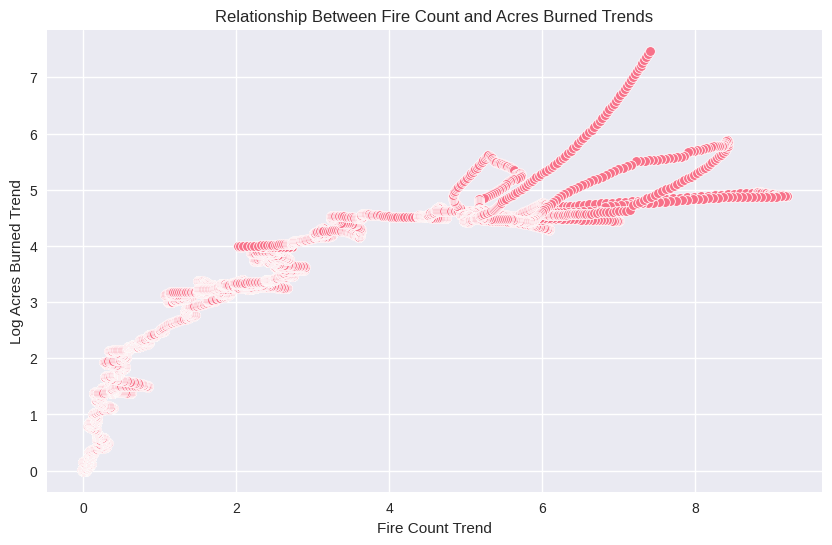

In [77]:
# Scatter plot of trend components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fire_trend', y='log_acres_trend', data=components)
plt.title('Relationship Between Fire Count and Acres Burned Trends')
plt.xlabel('Fire Count Trend')
plt.ylabel('Log Acres Burned Trend')
plt.show()

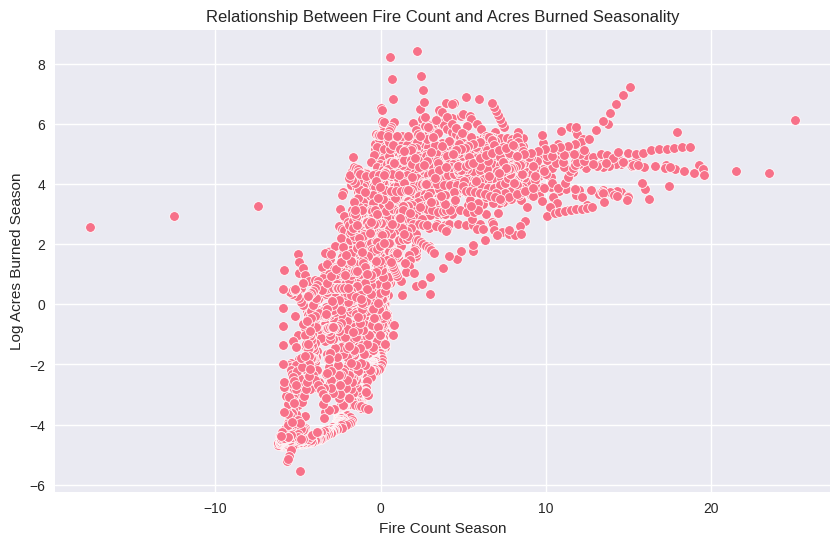

In [28]:
# Scatter plot of trend components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fire_seasonal', y='log_acres_seasonal', data=components)
plt.title('Relationship Between Fire Count and Acres Burned Seasonality')
plt.xlabel('Fire Count Season')
plt.ylabel('Log Acres Burned Season')
plt.show()

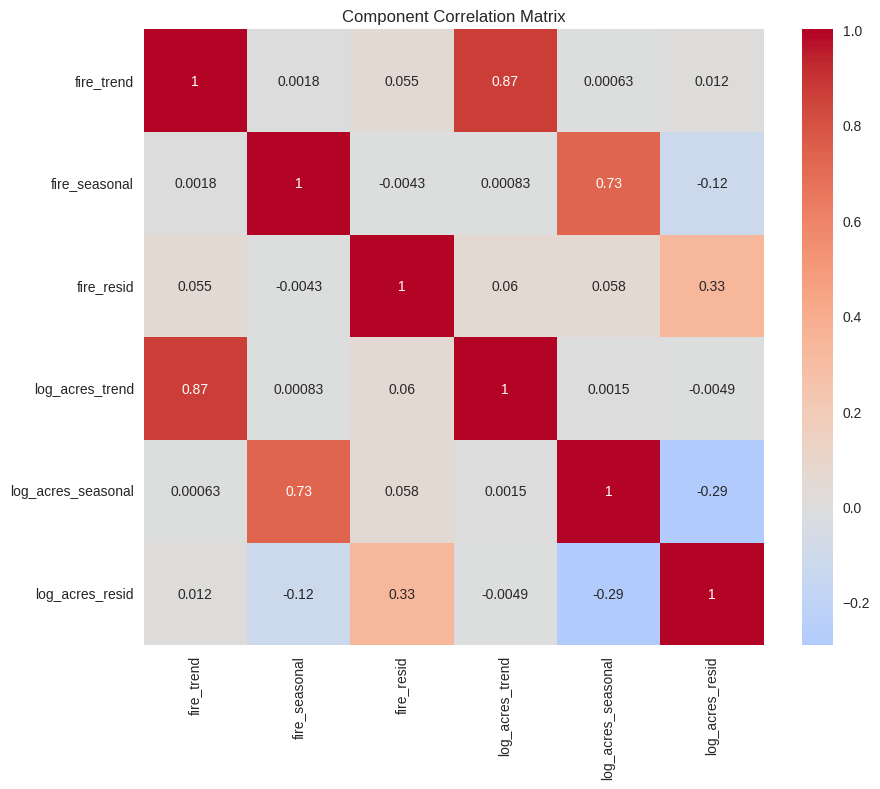

In [78]:
# Correlation matrix
corr_matrix = components[['fire_trend', 'fire_seasonal', 'fire_resid',
                         'log_acres_trend', 'log_acres_seasonal', 'log_acres_resid']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Component Correlation Matrix')
plt.show()

## 10. Anomaly Detection
Identify unusual periods using residuals

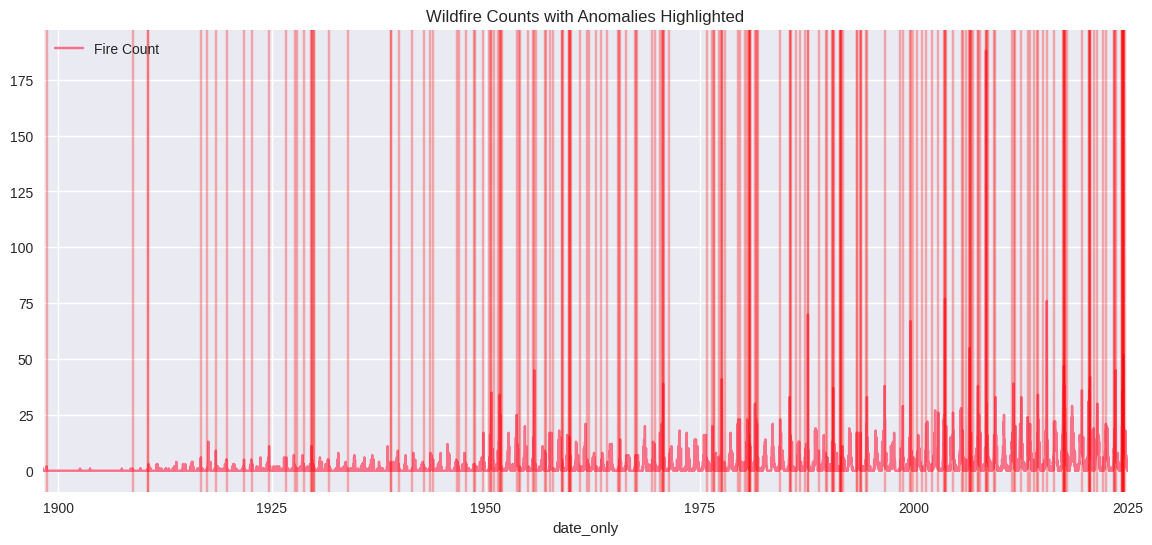

In [76]:
# Calculate z-scores of residuals
components['fire_resid_z'] = StandardScaler().fit_transform(components[['fire_resid']])
components['acres_resid_z'] = StandardScaler().fit_transform(components[['log_acres_resid']])

# Flag significant anomalies (|z-score| > 3)
components['fire_anomaly'] = np.abs(components['fire_resid_z']) > 3
components['acres_anomaly'] = np.abs(components['acres_resid_z']) > 3

# Plot anomalies
anomaly_dates = components[components['fire_anomaly'] | components['acres_anomaly']].index

fig, ax = plt.subplots(figsize=(14, 6))
weekly['fire_count'].plot(ax=ax, label='Fire Count')
for date in anomaly_dates:
    ax.axvline(date, color='red', alpha=0.3)
plt.title('Wildfire Counts with Anomalies Highlighted')
plt.legend()
plt.show()

## 11. Stationarizing the Data
Perform differencing to stationarize weekly fire counts.

In [29]:
data_diff = weekly['fire_count'] - weekly['fire_count'].shift(1)

In [30]:
data_diff.dropna(inplace = True)

In [31]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -24.401314
p-value                           0.000000
Number of Lags Used              35.000000
Number of Observations Used    6581.000000
Critical Value (1%)              -3.431344
Critical Value (5%)              -2.861979
Critical Value (10%)             -2.567004
dtype: float64


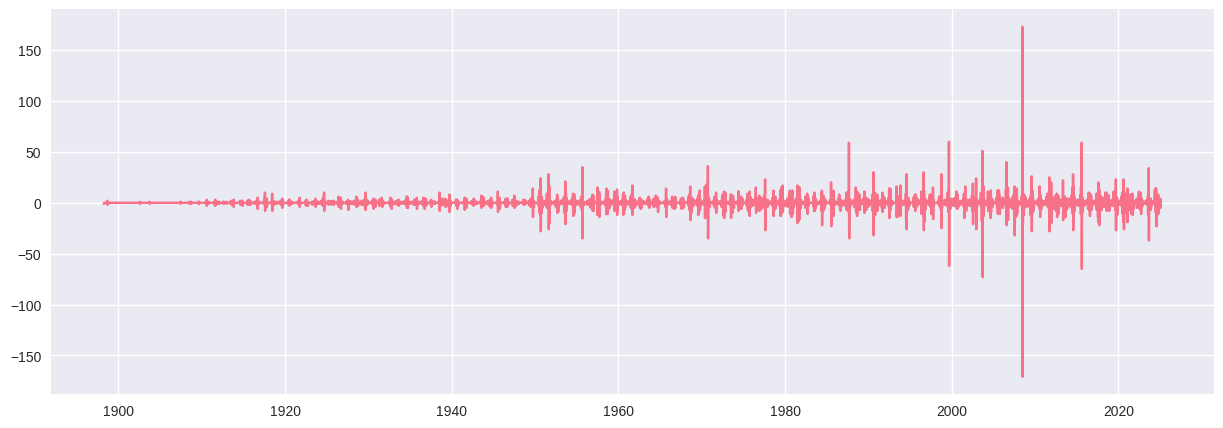

In [32]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

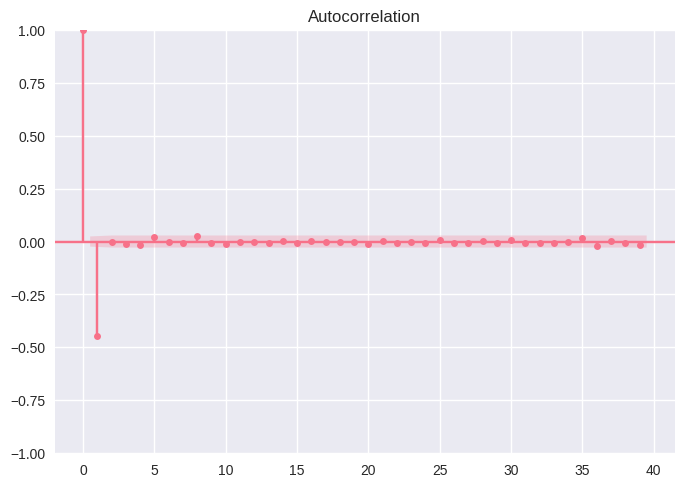

In [33]:
plot_acf(data_diff)
plt.show()

## 12. Export Components
Save decomposed components for further analysis

In [ ]:
# Add original data back in
output = pd.concat([weekly, components], axis=1)

# Save to CSV
output.to_csv('wildfire_stl_components.csv')